# 1 - Modelo de Regresion para Predecir costos de salud Personales
---

## 1.1 Cargando los datos


In [74]:
import pandas as pd
import numpy as np

#importar la biblioteca
from sklearn.metrics import r2_score

#bibliotecas para visualización
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Optimization
from sklearn.model_selection import KFold #división del dataset en n pedazos 
from sklearn.model_selection import cross_val_score #tecnica cross value
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#Ubicarme en la rais para poder utilizar todas las carpetas

from sys import path
import os

path.append(os.path.realpath('../'))

In [21]:
df = pd.read_csv('../../datasets/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1.2 Limpieza

### Tipos de variables

In [22]:
#Mucha atención al tipo de variables y al índice
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### Datos nulos 

In [23]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### Tipos de Datos

Listar variables continuas

In [24]:
columnas_continuas = df.select_dtypes(exclude=['object']).columns
columnas_continuas

Index(['age', 'bmi', 'children', 'charges'], dtype='object')

Listemos las variables categoricas

In [25]:
columas_cat = df.select_dtypes('object').columns
columas_cat

Index(['sex', 'smoker', 'region'], dtype='object')

* Sex: 0 y 1
* Smoker: 0 y 1
* region: ?  listare

In [26]:
df.region.value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [27]:
# PARA LAS VARIABLES SEX, SMOKER, REGION

df['sex'] = df['sex'].map({'male':1,'female':0})
df['smoker'] = df['smoker'].map({'yes':1,'no':0})
df['region'] = df['region'].map({'southwest':0,'southeast':1,'northwest':2,'northeast':3})

In [9]:
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
101,30,1,25.460,0,0,3,3645.08940
626,36,1,28.880,3,0,3,6748.59120
1277,32,0,29.735,0,0,2,4357.04365
309,41,0,33.060,2,0,2,7749.15640
510,56,1,32.110,1,0,3,11763.00090


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   int64  
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 73.3 KB


In [28]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# 2 - EDA
---

## 2.1 Variable Objetivo

(1338, 7)


<Axes: >

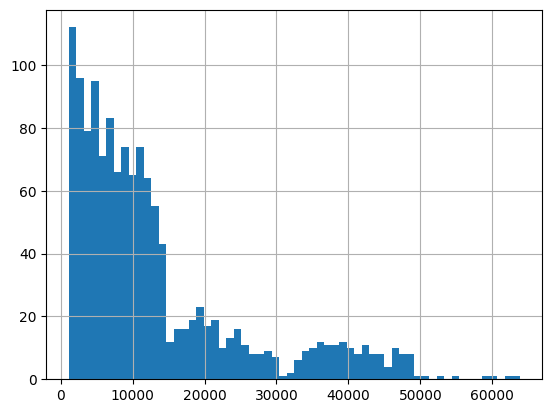

In [29]:
print(df.shape)
df.charges.hist(bins = 60)

Se observa que la variable a predecir tiene sesgo positivo, por lo que para obtner mejores resultados del modelo este se procedera a normalizar mediante el metodo de logaritmo.

Ademas se observa que aprox. partir de 49,000 no se tienen muchos datos por lo que verificamos si es necesario mantener esos datos o no..

In [10]:
df[df.charges>=49000]

,age,sex,bmi,children,smoker,region,charges
34,28,1,36.400,1,1,0,51194.55914
543,54,0,47.410,0,1,1,63770.42801
577,31,0,38.095,1,1,3,58571.07448
819,33,0,35.530,0,1,2,55135.40209
1146,60,1,32.800,0,1,0,52590.82939
1230,52,1,34.485,3,1,2,60021.39897
1241,64,1,36.960,2,1,1,49577.66240
1300,45,1,30.360,0,1,1,62592.87309


al tener solo 7 registros, procedermos a retirarlos para no generar ruido en el modelo posterior

In [30]:
df = df[df.charges<=49000]

Imporante al eliminar resetear los indices!

In [31]:
# Restablecer el índice después de eliminar filas
df = df.reset_index(drop=True)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1330 non-null   int64  
 1   sex       1330 non-null   int64  
 2   bmi       1330 non-null   float64
 3   children  1330 non-null   int64  
 4   smoker    1330 non-null   int64  
 5   region    1330 non-null   int64  
 6   charges   1330 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 72.9 KB


In [203]:
df.shape

(1330, 7)

## 2.2 Correlacion

In [32]:
correlacion = df.corr()
correlacion

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.023776,0.107120,0.042261,-0.031111,0.000057,0.301875
sex,-0.023776,1.000000,0.048178,0.015493,0.074439,-0.001244,0.055417
bmi,0.107120,0.048178,1.000000,0.014283,-0.007734,-0.157890,0.185376
children,0.042261,0.015493,0.014283,1.000000,0.009977,-0.018153,0.075527
smoker,-0.031111,0.074439,-0.007734,0.009977,1.000000,0.004763,0.784986
region,0.000057,-0.001244,-0.157890,-0.018153,0.004763,1.000000,0.010377
charges,0.301875,0.055417,0.185376,0.075527,0.784986,0.010377,1.000000


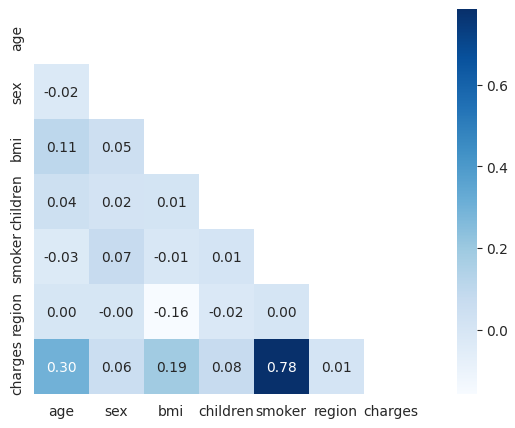

In [33]:
#visualización de las correlaciones
cores = sns.color_palette('light:salmon', as_cmap=True)
mask = np.zeros_like(correlacion)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 5))
    ax = sns.heatmap(correlacion, cmap="Blues", mask=mask, square=True, fmt='.2f', annot=True)

Se observa que las variables predictoras: Smoker, age y en menor manera bmi estan mas relacionadas a la variable charges

## 2.3 Exploratory data

### Charges por smoker y age

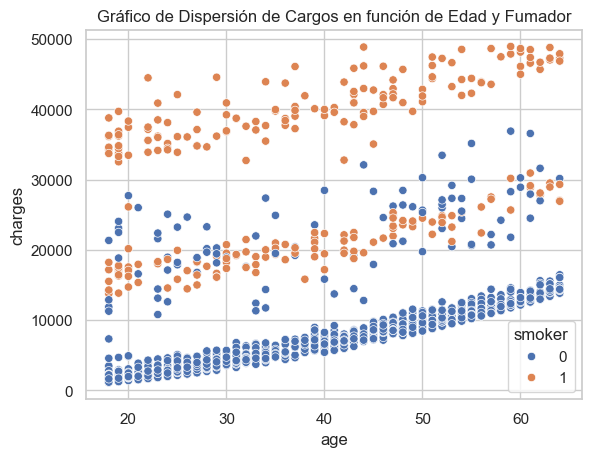

In [118]:
sns.scatterplot(x='age', y='charges', hue='smoker', data=df)

# Mostrar el gráfico
plt.title('Gráfico de Dispersión de Cargos en función de Edad y Fumador')
plt.show()

* Se observa que los no fumadores tienden a tener menos gastos. Ocacionalmente tienen gastos altos y esto es ovbio ya que pueden sufrir accidentes o tratar 
enfermadades costosas
* A mas edad mayores gastos medicos


### BMI : Indice de masa corporal  

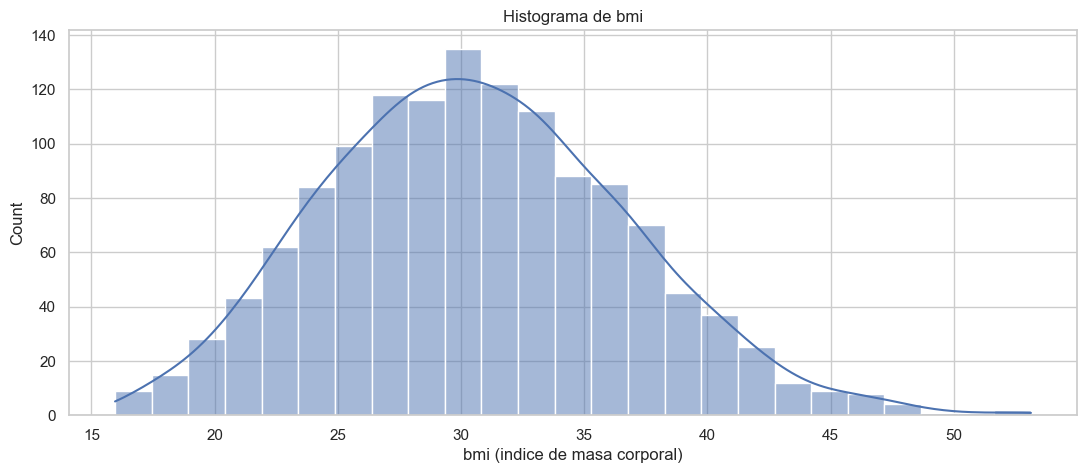

In [119]:
ax = sns.histplot(data=df, x='bmi', kde=True)
ax.figure.set_size_inches(13, 5)
ax.set_title('Histograma de bmi')
ax.set_xlabel('bmi (indice de masa corporal)');

podriamos clasificar el bmi en 4 grupos

peso bajo (IMC inferior a 18.5) / peso normal o saludable (IMC de 18.5 a 24.9) / sobrepeso (IMC de 25.0 a 29.9) / obeso (IMC de 30 o más)

In [83]:
df_up = df.copy()

In [85]:
df_up['categoria_bmi'] = pd.cut(df_up['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')],
                             labels=['Peso Bajo', 'Normal', 'Sobrepeso', 'Obeso'])

# Crear la columna "categoria_bmi_n" como valor numérico de "categoria_bmi"
categorias_numericas = {'Peso Bajo': 1, 'Normal': 2, 'Sobrepeso': 3, 'Obeso': 4}
df_up['categoria_bmi_n'] = df_up['categoria_bmi'].map(categorias_numericas)

df_up


,age,sex,bmi,children,smoker,region,charges,categoria_bmi,categoria_bmi_n
0,19,0,27.900,0,1,0,16884.92400,Sobrepeso,3
1,18,1,33.770,1,0,1,1725.55230,Obeso,4
2,28,1,33.000,3,0,1,4449.46200,Obeso,4
3,33,1,22.705,0,0,2,21984.47061,Normal,2
4,32,1,28.880,0,0,2,3866.85520,Sobrepeso,3
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2,10600.54830,Obeso,4
1334,18,0,31.920,0,0,3,2205.98080,Obeso,4
1335,18,0,36.850,0,0,1,1629.83350,Obeso,4
1336,21,0,25.800,0,0,0,2007.94500,Sobrepeso,3


Como se distribuye el bmi segun la edad

C:\Users\Rez3t\AppData\Local\Temp\ipykernel_8624\2503188244.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='categoria_bmi', data=df_up, palette='pastel')


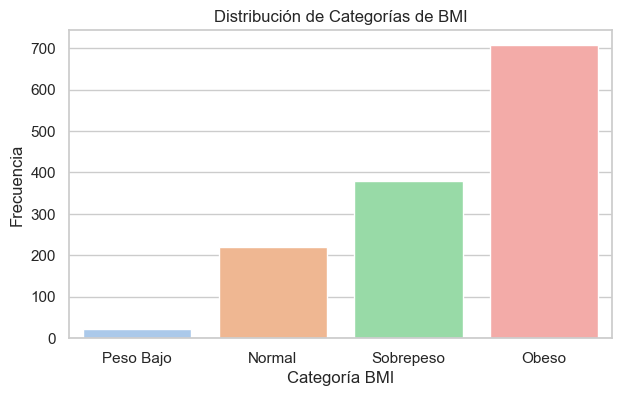

In [86]:
# Crear un gráfico de barras para la categoría BMI
plt.figure(figsize=(7, 4))
sns.set(style="whitegrid")

# Plotear el gráfico de barras para la categoría BMI
sns.countplot(x='categoria_bmi', data=df_up, palette='pastel')

# Agregar título y etiquetas de ejes
plt.title('Distribución de Categorías de BMI')
plt.xlabel('Categoría BMI')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

Como se distribuye los gastos por edad y categoria IMC

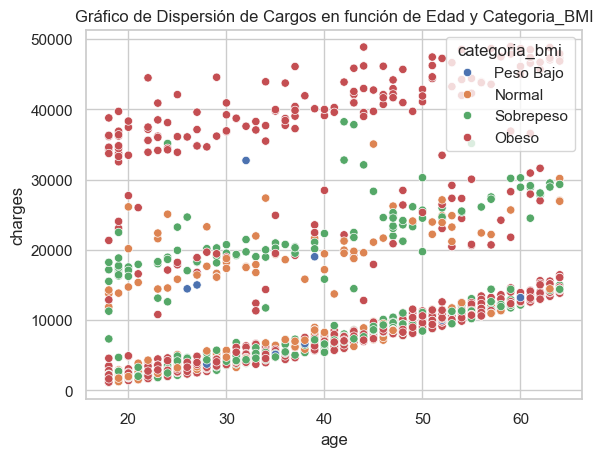

In [87]:
sns.scatterplot(x='age', y='charges', hue='categoria_bmi', data=df_up)

# Mostrar el gráfico
plt.title('Gráfico de Dispersión de Cargos en función de Edad y Categoria_BMI')
plt.show()

Se oberva que los obesos tienen los gastos mas altos, seguido por el sobrepeso. Esto es de por si obvio debido a que estan mas propensos a contraer enfermedades y mayores cuidados

In [88]:
df_up = df_up.drop ('categoria_bmi', axis = 1)

In [89]:
correlacion_up = df_up.corr()
correlacion_up

,age,sex,bmi,children,smoker,region,charges,categoria_bmi_n
age,1.000000,-0.023776,0.107120,0.042261,-0.031111,0.000057,0.301875,0.106339
sex,-0.023776,1.000000,0.048178,0.015493,0.074439,-0.001244,0.055417,0.041964
bmi,0.107120,0.048178,1.000000,0.014283,-0.007734,-0.157890,0.185376,0.849980
children,0.042261,0.015493,0.014283,1.000000,0.009977,-0.018153,0.075527,0.003228
smoker,-0.031111,0.074439,-0.007734,0.009977,1.000000,0.004763,0.784986,-0.023320
region,0.000057,-0.001244,-0.157890,-0.018153,0.004763,1.000000,0.010377,-0.133488
charges,0.301875,0.055417,0.185376,0.075527,0.784986,0.010377,1.000000,0.174955
categoria_bmi_n,0.106339,0.041964,0.849980,0.003228,-0.023320,-0.133488,0.174955,1.000000


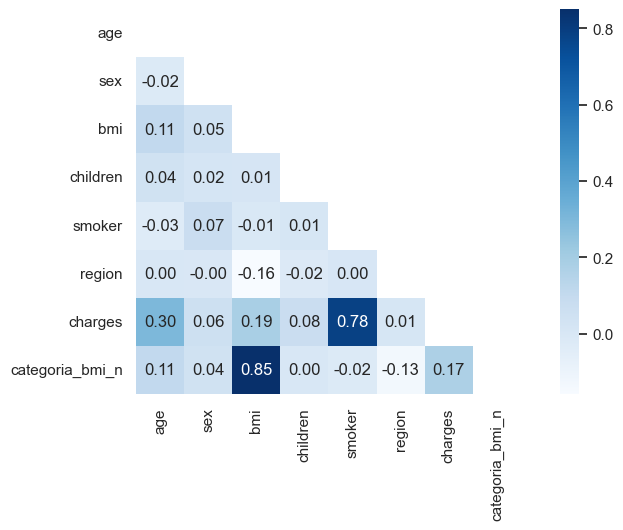

In [90]:
#visualización de las correlaciones
cores = sns.color_palette('light:salmon', as_cmap=True)
mask = np.zeros_like(correlacion_up)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 5))
    ax = sns.heatmap(correlacion_up, cmap="Blues", mask=mask, square=True, fmt='.2f', annot=True)

# 3 - Preparacion de los datos
---

Anteriormente se observo que la variable charges no tenia forma normal, por lo que se procedera normalizar a las variables continuas. NO se considerara a las variables Categoricas

In [34]:
columas_cat

Index(['sex', 'smoker', 'region'], dtype='object')

In [35]:
# Recordando cuales eran las variables continuas iniciales
columnas_continuas

Index(['age', 'bmi', 'children', 'charges'], dtype='object')

## 3.1 - Transformacion Logaritmica

### Efectuar transformacion

In [36]:
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p, validate=True)
#datos_transformados = transformer.transform(df.select_dtypes(exclude=['object']))
datos_transformados = transformer.transform(df[columnas_continuas])

d:\STUDY\Python\Machine_Learning\env\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


In [37]:
type(datos_transformados)

numpy.ndarray

In [38]:
#columnas_datos_tranformados = df.select_dtypes(exclude=['object']).columns
columnas_datos_tranformados = df[columnas_continuas].columns

#df_transformado = pd.concat([datos_inmuebles.select_dtypes(include=['object']), pd.DataFrame(datos_transformados, columns=columnas_datos_tranformados)], axis=1)
df_transformado = pd.concat([df[columas_cat], pd.DataFrame(datos_transformados, columns=columnas_datos_tranformados)], axis=1)
df_transformado.head()

,sex,smoker,region,age,bmi,children,charges
0,0,1,0,2.995732,3.363842,0.000000,9.734236
1,1,0,1,2.944439,3.548755,0.693147,7.453882
2,1,0,1,3.367296,3.526361,1.386294,8.400763
3,1,0,2,3.526361,3.165686,0.000000,9.998137
4,1,0,2,3.496508,3.397189,0.000000,8.260455


In [18]:
df_transformado.shape


(1330, 7)

### Visualizar transformacion normal

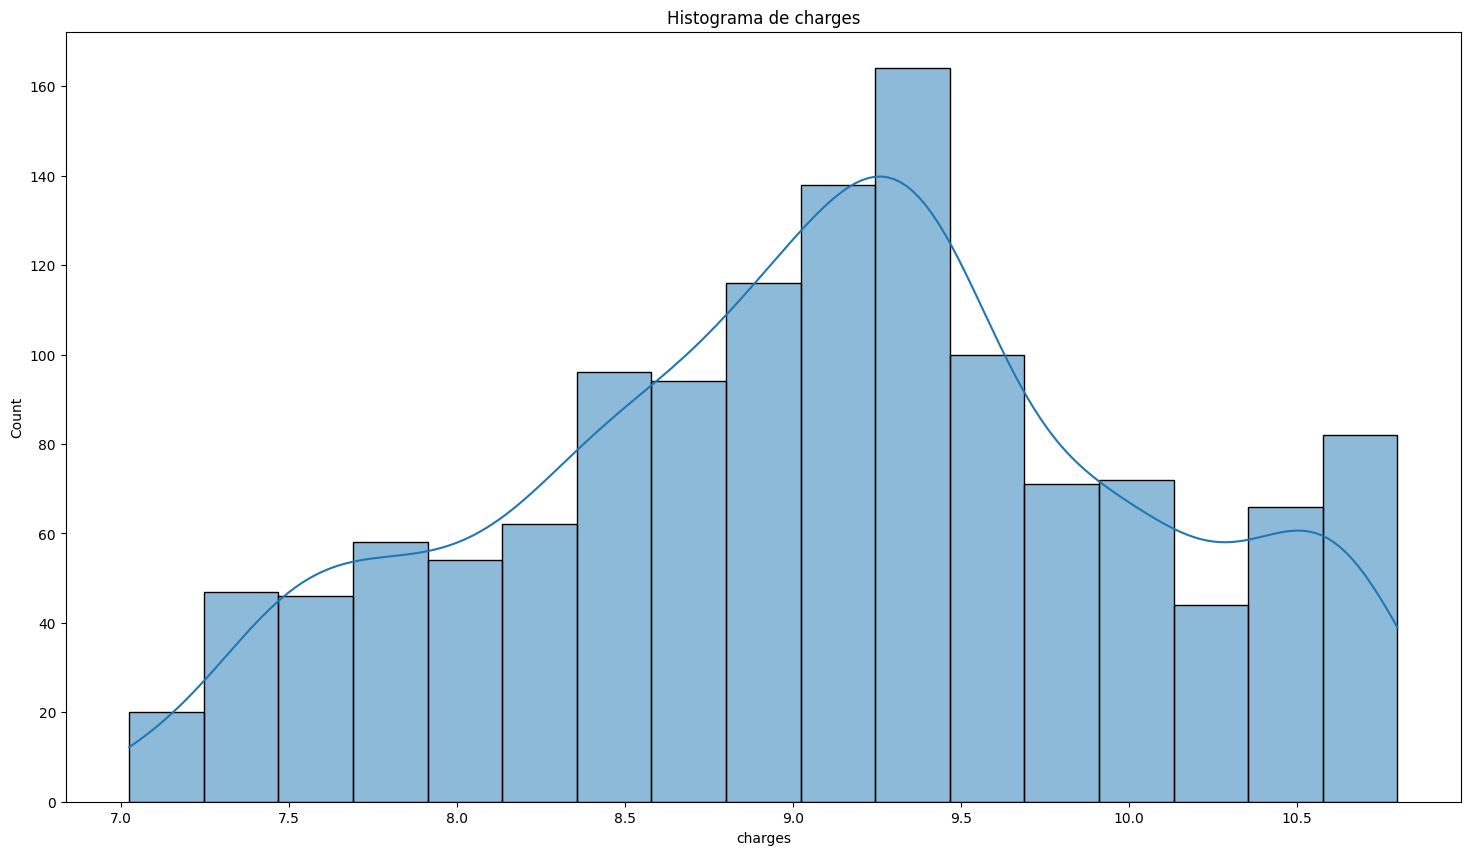

In [39]:
#después (distribución simétrica)
ax = sns.histplot(data=df_transformado, x='charges', kde=True)
ax.figure.set_size_inches(18, 10)
ax.set_title('Histograma de charges')
ax.set_xlabel('charges');

Se mejoro la asimetria y se normalizo (gaus) nuestra variable a predecir

# 4 - Modelos de Regresion
---

## Division de datos

In [44]:
#variables independientes
X = df_transformado.drop('charges', axis=1)

#variable dependiente
y = df_transformado['charges']

In [217]:
# from sklearn.model_selection import train_test_split

In [46]:
#división en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 4.1 - Regresion Lineal

In [219]:
# from sklearn.linear_model import LinearRegression

In [47]:
#Inicializando el modelo
lr = LinearRegression()

In [48]:
#Entrenamiento
lr.fit(X_train, y_train)

LinearRegression()

In [49]:
#Prueba
prediccion_lr = lr.predict(X_test)

In [50]:
#Resultados de la predicción
prediccion_lr

array([ 7.94321746,  9.34986745,  9.12369578,  8.89101528,  9.46168059,
        8.486814  ,  8.24864215,  7.73836257,  9.35514292,  8.0924111 ,
        8.29373135,  9.18134869,  8.36592624,  7.98346528,  7.9954649 ,
        9.31944162,  9.08838329,  8.71402107,  8.99891349, 10.27158161,
        9.43586665,  8.73192682,  7.80172026,  7.7591279 , 10.52735521,
       10.68615978,  8.86437083,  8.68940791,  9.23968465,  8.50105794,
       10.06681074,  8.67340822, 10.63709549,  8.11582049,  7.90954609,
        8.85176453,  9.37814552,  9.48606803,  7.94714436, 10.63475351,
        9.38159354,  7.77567538,  8.90504474, 10.56645301,  9.3598501 ,
        9.35706978,  9.35975856,  8.16834739,  8.15457956,  8.85067051,
        7.85470119,  9.36235211, 10.63755545,  8.25198788, 10.31488249,
        9.21349073,  9.59637539,  8.0162564 ,  9.13870984,  8.63364919,
        9.32879086,  8.88539289,  9.06126781,  8.52414479,  8.93314064,
        9.13239865,  8.5477911 ,  8.81151522, 10.6141744 ,  9.07

In [51]:
#transformación inversa
np.expm1(7.94321746)

2815.4076250050043

### Metricas del modelo RL

In [52]:
r2_lr = r2_score(y_test, prediccion_lr)
r2_lr

0.7719531337637198

## 4.2 - Desicion Three

In [229]:
# from sklearn.tree import DecisionTreeRegressor

In [55]:
#Inicializando el modelo
dtr = DecisionTreeRegressor(random_state=42, max_depth=5)

In [56]:
#Entrenamiento
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [57]:
#Prueba
prediccion_dtr = dtr.predict(X_test)

In [233]:
#Resultados de la predicción
prediccion_dtr

array([ 7.88874821,  9.43982817,  9.15894865,  8.92794796,  9.74257208,
        8.39139786,  8.8772317 ,  7.47229006,  9.59668457,  7.98661487,
        8.50536361,  9.43982817,  8.50536361,  7.76382232,  7.47229006,
        9.59668457,  8.92794796,  8.74564498,  8.8772317 ,  9.89160747,
        9.59668457,  8.48982788,  7.47229006,  7.47229006, 10.11869921,
       10.61299606,  8.74564498,  8.74564498,  9.59668457,  8.39139786,
       10.53711559,  8.50536361, 10.02440931,  8.8772317 ,  7.76382232,
        8.8772317 ,  9.43982817,  9.59668457,  8.8772317 , 10.60270532,
        9.59668457,  7.88874821,  8.74564498, 10.11869921,  9.59668457,
        9.59668457,  9.15894865,  7.76382232,  7.88874821,  8.74564498,
        7.88874821,  9.43982817, 10.11869921,  7.98661487,  9.89160747,
        9.29358554,  9.59668457,  7.76382232,  9.43982817,  8.8772317 ,
        9.59668457,  8.74564498,  9.1407594 ,  8.8772317 ,  8.74564498,
        9.1407594 ,  8.48982788,  8.92794796, 10.02440931,  8.92

C:\Users\Rez3t\AppData\Local\Temp\ipykernel_10444\230932302.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_test,hist=False,color='r',label='Actual Value')
C:\Users\Rez3t\AppData\Local\Temp\ipykernel_10444\230932302.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

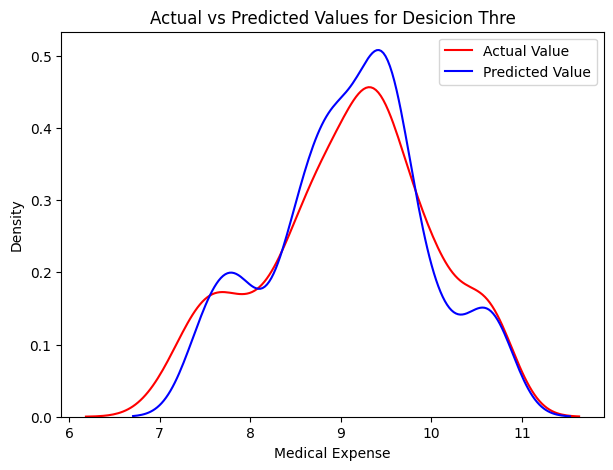

In [58]:
#distribution of actual and predicted values
plt.figure(figsize=(7,5))
ax1 = sns.distplot(y_test,hist=False,color='r',label='Actual Value')
sns.distplot(prediccion_dtr,hist=False,color='b',label='Predicted Value',ax=ax1)
plt.title('Actual vs Predicted Values for Desicion Thre')
plt.xlabel('Medical Expense')
plt.legend() 
plt.show()

### Metricas del modelo Desicion Three

In [59]:
#coeficiente de determinación
r2_dtr = r2_score(y_test, prediccion_dtr)
r2_dtr

0.8223646590935023

## 4.3 - Random Forest

**Observación**
Los parámetros son prácticamente los mismos entre `DecisionTreeRegressor()` y `RandomForestRegressor()`, con la excepción de:

* `n_estimators`: número de árboles en el bosque
* `bootstrap`: define si se utilizará el método de muestreo estadístico *bootstrap*
* `oob_score`: define si se utilizará el método de muestreo *out-of-bag* para medir los errores de predicción
* `n_jobs`: número de *jobs* que se ejecutan en paralelo (computación paralela - procesadores)
* `warm_start`: adecuación de un nuevo bosque o usa un bosque existente.
* `max_samples`: en caso de que `bootstrap` sea `True`, define el número de muestras que se extraerán de X para entrenar cada árbol base.

In [236]:
# from sklearn.ensemble import RandomForestRegressor

In [61]:
rf = RandomForestRegressor(random_state=42, max_depth=5, n_estimators=10)

In [62]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42)

In [63]:
prediccion_rf = rf.predict(X_test)

**Gráfico de predicion vs real**

C:\Users\Rez3t\AppData\Local\Temp\ipykernel_10444\588918312.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_test,hist=False,color='r',label='Actual Value')
C:\Users\Rez3t\AppData\Local\Temp\ipykernel_10444\588918312.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

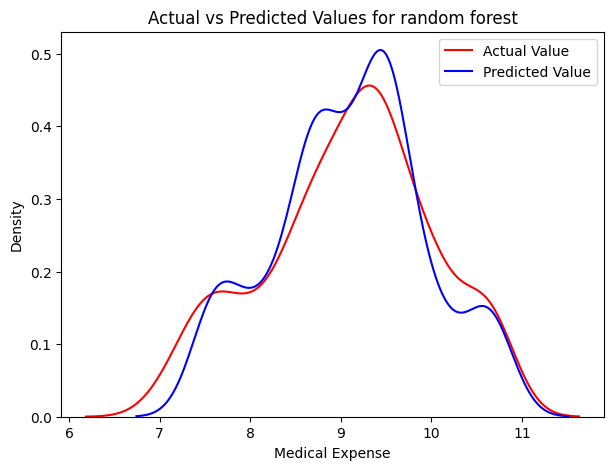

In [64]:
#distribution of actual and predicted values
plt.figure(figsize=(7,5))
ax1 = sns.distplot(y_test,hist=False,color='r',label='Actual Value')
sns.distplot(prediccion_rf,hist=False,color='b',label='Predicted Value',ax=ax1)
plt.title('Actual vs Predicted Values for random forest')
plt.xlabel('Medical Expense')
plt.legend() 
plt.show()

In [65]:
#coeficiente de determinación
r2_rf = r2_score(y_test, prediccion_rf)
r2_rf

0.8262862489497491

# 5 - OPTIMIZACION DEL MODELO
---

## 5.1 - Optimizando el árbol de decisión

In [68]:
#división del dataset en n pedazos
#from sklearn.model_selection import KFold

#definiendo el K - número de subconjuntos
cv = KFold(n_splits = 5, shuffle=True)

### Cross validation


In [ ]:
# from sklearn.model_selection import cross_val_score

In [71]:
accuracy_cross_val_r2 = cross_val_score(estimator = dtr,
                                       X = X_train,
                                       y = y_train,
                                       scoring = 'r2',
                                       cv = cv)
print('Accuracy promedio de r2: {}'.format(round(accuracy_cross_val_r2.mean(), 3)))

Accuracy promedio de r2: 0.807


### Random Search Validation

In [295]:
#selección de hiperparametros
param_random_dt = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [6, 8, 10, 12, 14, 16,18,20,22,24,26,28],
    'min_samples_leaf': [6, 8, 10,12],
    'min_samples_split': [8, 10, 12, 14, 16],
    'max_features': ['sqrt', 'log2', 0.5]
}


In [225]:
# from sklearn.model_selection import RandomizedSearchCV

In [203]:
random_cv_dt = RandomizedSearchCV(
    dtr,
    param_random_dt,
    n_iter=15,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    error_score=0
)

In [226]:
randomcv_dtr = random_cv_dt.fit(X_train, y_train)

In [ ]:
# pd.DataFrame(randomcv_dtr.cv_results_)

In [227]:
#la mejor combinación
randomcv_dtr.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 6,
 'max_features': 0.5,
 'max_depth': 16,
 'criterion': 'absolute_error'}

In [228]:
#el mejor score
randomcv_dtr.best_score_

0.7862832934264601

### Random Search Test

In [259]:
dtr_optimizado = DecisionTreeRegressor(min_samples_split = 10,
 min_samples_leaf = 6,
 max_features = 0.5,
 max_depth = 16,
 criterion= 'absolute_error')

In [260]:
dtr_optimizado.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=16,
                      max_features=0.5, min_samples_leaf=6,
                      min_samples_split=10)

In [261]:
prediccion_dtr_optimizado = dtr_optimizado.predict(X_test)

In [262]:
r2_score(y_test, prediccion_dtr_optimizado)

0.8015630382738301

## 5.2 - Optimizando el Bosque de árboles de decisión

### Cross validation

In [263]:
accuracyRF_cross_val_r2 = cross_val_score(estimator = rf,
                                       X = X_train,
                                       y = y_train,
                                       scoring = 'r2',
                                       cv = cv)
print('Accuracy promedio de r2: {}'.format(round(accuracyRF_cross_val_r2.mean(), 3)))

Accuracy promedio de r2: 0.822


### Random Search Validation

Definiendo los parámetros

In [335]:
'''
param_random_rf = {
    'n_estimators': [150, 200],
    'max_depth': [20, 30],
    'min_samples_split': [8, 10],
    'min_samples_leaf': [3],
}
'''

param_random_rf = [{
    'n_estimators' : [50, 80, 100, 130, 150, 180, 200],
    'max_depth' :  [20, 30, 40 ,50 , 60 ,70],
    'min_samples_split' : [6,8, 10,12,14],
    'min_samples_leaf' : [3,6,9,12,15,18]
    }]

In [336]:
random_cv_rf = RandomizedSearchCV(
    rf,
    param_random_rf,
    n_iter=5,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    random_state = 42
)

In [337]:
rf_randomcv = random_cv_rf.fit(X_train, y_train)

In [338]:
pd.DataFrame(rf_randomcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.487212,0.027430,0.012150,0.009546,200,6,9,70,"{'n_estimators': 200, 'min_samples_split': 6, ...",0.771353,0.853348,0.829588,0.897579,0.785863,0.827546,0.045759,1
1,0.683118,0.033059,0.019028,0.013215,200,10,3,60,"{'n_estimators': 200, 'min_samples_split': 10,...",0.770440,0.846618,0.823780,0.886916,0.782877,0.822126,0.042455,5
2,0.359569,0.028184,0.007444,0.009240,130,8,9,70,"{'n_estimators': 130, 'min_samples_split': 8, ...",0.769973,0.853262,0.829202,0.898256,0.783728,0.826884,0.046683,3
3,0.365104,0.016561,0.003521,0.006099,130,8,6,70,"{'n_estimators': 130, 'min_samples_split': 8, ...",0.775423,0.853150,0.825074,0.894560,0.781314,0.825904,0.044706,4
4,0.171557,0.006614,0.004593,0.005936,80,14,18,60,"{'n_estimators': 80, 'min_samples_split': 14, ...",0.767884,0.845426,0.841825,0.900758,0.781737,0.827526,0.048045,2


In [339]:
rf_randomcv.best_params_

{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 9,
 'max_depth': 70}

In [340]:
rf_randomcv.best_score_

0.8275460924522948

### Random Search Test

In [341]:
rf_optimizado2 = RandomForestRegressor(random_state=42, max_depth=60, n_estimators=150,
                                      min_samples_leaf=15, min_samples_split=8)

In [342]:
rf_optimizado2.fit(X_train, y_train)

RandomForestRegressor(max_depth=60, min_samples_leaf=15, min_samples_split=8,
                      n_estimators=150, random_state=42)

In [343]:
prediccion_rf_optimizado2 = rf_optimizado2.predict(X_test)

In [345]:
r2_score(y_test, prediccion_rf_optimizado2)

0.8297235712787564

## 5.3 - Escogiendo el mejor modelo

In [346]:
print('r2 score inicial')
print("-"*30)
print("Arbol de Decisión: %f" % r2_dtr)
print("Random Forest: %f" % r2_rf)
print("-"*30)
print(" "*30)

#tabla de resultados
print('Random Search')
print("="*30)
print("Arbol de Decisión: %f" % r2_score(y_test, prediccion_dtr_optimizado))
print("Random Forest: %f" % r2_score(y_test, prediccion_rf_optimizado2))
print("*"*30)

print("Cross Validation")
print("="*30)
print("Arbol de Decisión: %f" % round(accuracy_cross_val_r2.mean(), 3))
print("Random Forest: %f" % round(accuracyRF_cross_val_r2.mean(), 3))

r2 score inicial
------------------------------
Arbol de Decisión: 0.822365
Random Forest: 0.826286
------------------------------
                              
Random Search
Arbol de Decisión: 0.801563
Random Forest: 0.829724
******************************
Cross Validation
Arbol de Decisión: 0.807000
Random Forest: 0.822000


Random Forest ofrece una mejor presicion al modelo : rf_optimizado2